# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import sys

import time # just for dev purpose
from IPython.display import display # Just for displaying DF nicely

from itertools import product

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt

from util.util import *
from util.const import conceptNames

### Reading only one file

Validation Logs created in validationLogCreation.ipynb

In [2]:
# Validation Logs
csvPath = "logs/smartRPA/validation_noShuffle_noReduction/"
csvPath = "logs/smartRPA/validation_5shuffle_5reduction/"
csvPath = "logs/smartRPA/validation_10shuffle_10reduction/"

filename = "Log_1_2_5_19200.csv"

df = pd.read_csv(csvPath + filename, encoding = "latin-1")

### Getting the tuple data ready
#### Agostinelli Log

In [3]:
#### Encoding of Application ####
# Update dict creation to sort the data before to create meaningful dicts -> Equal applications are grouped together for example
# By Appearing in the UI Log > Continuous hot encoding
applicationDict = createDict(set(df['application'].unique()))


#### Encoding of concept:name / action ####
# Concept Name Encoding -> Use One
# By Appearing in the UI Log > Continuous hot encoding
conceptNamesDict = createDict(set(df.sort_values(by=['concept:name'])['concept:name'].unique()))


#### Encoding of Category ####
# Categories > No specific encoding sequence as it is few values. Does not matter.
categoriesDict = createDict(set(df.sort_values(by=['category'])['category'].unique()))

# Add as new column to the dataframe
df['application:id'] = df.apply(lambda row: get_key(row, applicationDict, 'application'), axis=1)
df['concept:name:id'] = df.apply(lambda row: get_key(row, conceptNamesDict, 'concept:name'), axis=1)
df['category:id'] = df.apply(lambda row: get_key(row, categoriesDict, 'category'), axis=1)


print(f"The number of concept names is {len(conceptNamesDict)}, of applications is {len(applicationDict)}, and categories is {len(categoriesDict)}")
# print(df[["time:timestamp",'concept:name', 'application', 'category', 'concept:name:id', 'application:id', 'category:id']])

The number of concept names is 40, of applications is 10, and categories is 3


Make the multi dimensional Agostinelli log one dimensional using another tuple generator

Using the ideas ('concept:name:id','application:id', 'category:id') generated earlier in the process based on the dictonaries 

In [7]:
numbersDF = df[['concept:name:id', 'application:id', 'category:id']]

# Generate unique tuples for indexing the individual combinations of the rows mentioned
unique_df = numbersDF.drop_duplicates(subset=numbersDF.columns, keep='first')
tuples = [tuple(row[['concept:name:id', 'application:id', 'category:id']]) for i, row in unique_df.sort_values(by='application:id').iterrows()]
       
df['id'] = df.apply(lambda row: get_id(row, tuples, columns=['concept:name:id','application:id', 'category:id']), axis=1)
# Print the updated DataFrame
print(df[['time:timestamp','id']])

                time:timestamp  id
0      2020-03-14T06:35:11.000  34
1      2020-03-28T13:15:16.000   9
2      2020-09-13T18:18:13.000  34
3      2020-07-10T17:17:30.000  33
4      2020-02-28T02:19:28.000  32
...                        ...  ..
19425  2020-01-11T11:32:21.000  27
19426  2020-05-04T01:19:42.000  25
19427  2020-02-28T02:20:00.000  32
19428  2020-06-21T03:16:11.000  31
19429  2020-09-29T05:12:42.000   8

[19430 rows x 2 columns]


### Display different ordering clusters
Timeseries data is continuous and thus the process mining data has to be transformed in a way that it does represent a continuous spectrum of values.

We test the following approaches to create the timeseries integer values for a continuous spectrum:
- Tuple ID by occurance: The first occurance gets ID=1, the second ID=2, and so on. This leads to a spectrum based on value occurance
- Tuple ID by application: Similar applications should get similar tuple IDs. Thus, we define a list of applications that can occurr in the log and order the applications by similarity. E.g. Firefox and Chrome have closer tuple values compared to Firefox and Outlook.
- Tuple ID by action: Similar actions get similar IDs. Thus, we cluster the actions based on their generic type. We suggest the clustering based on:
    - mouse interactions, keyboard interactions, and other interactions.
    - the generic action types "Open" "Close" "Navigate" "Transform" "Transfer" "Empty" "Conclude"

Based on the sorting we check the quality of the data distribution by the mean difference between the tuple IDs in the log.
I.e. we calculate the difference between all occurring values in the log and take the mechanism creating the smallest average difference between consequitive occurances.

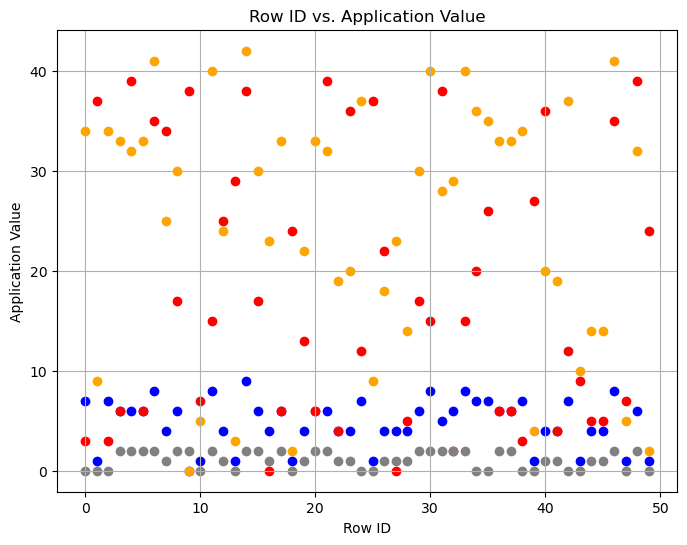

In [9]:
first_50_rows = df.iloc[:50]

# Get row IDs (index starts from 0)
row_ids = first_50_rows.index

# Extract application values
application_values = first_50_rows['application:id'].to_numpy()  # Convert to NumPy array for efficiency
concept_names = first_50_rows['concept:name:id'].to_numpy()  
categories_values = first_50_rows['category:id'].to_numpy()  
tuple_ids = first_50_rows['id'].to_numpy() 

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(row_ids, application_values, color='blue')
plt.scatter(row_ids, concept_names, color='red')
plt.scatter(row_ids, categories_values, color='grey')
plt.scatter(row_ids, tuple_ids, color='orange')
plt.xlabel('Row ID')
plt.ylabel('Application Value')
plt.title('Row ID vs. Application Value')
plt.grid(True)
plt.show()

In [10]:
# Calculate differences between consecutive values (avoid first element)
differences_app = df['application:id'].diff(periods=-1)  # Avoids unnecessary row iteration
differences_app.iloc[0] = pd.NA  # Set difference for the first row to not-a-number (optional)

differences_concept = df['concept:name:id'].diff(periods=-1) 
differences_concept.iloc[0] = pd.NA  

differences_cat = df['category:id'].diff(periods=-1)  
differences_cat.iloc[0] = pd.NA  

differences_tuple = df['id'].diff(periods=-1)  
differences_tuple.iloc[0] = pd.NA

# Calculate the mean of absolute differences (mean jump)
mean_jump_app = differences_app.abs().mean()
mean_jump_conceptname = differences_concept.abs().mean()
mean_jump_cat = differences_cat.abs().mean()
mean_jump_tup = differences_tuple.abs().mean()

print("Mean alteration rate between consecutive application:id values:", mean_jump_app) # Best score so far when just taking apps as they come at 1.8
print("Mean alteration rate between consecutive concept:name:id values:", mean_jump_conceptname) # best score if only concepts are considered that appear in the df at 12.6 (if all actions are considered ~36)
print("Mean alteration rate between consecutive category:id values:", mean_jump_cat) 
print("Mean alteration rate between consecutive tuple id values:", mean_jump_tup) # score does not change a lot, best score around 9.3/9.4

Mean alteration rate between consecutive application:id values: 2.3316862260654725
Mean alteration rate between consecutive concept:name:id values: 15.387173152151535
Mean alteration rate between consecutive category:id values: 0.8077002264772494
Mean alteration rate between consecutive tuple id values: 12.59012765081326


Modelling the data in a 3D space

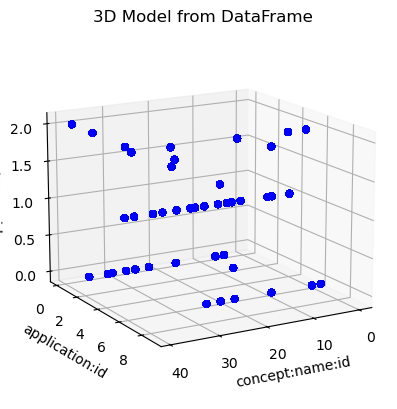

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract data from each column
x = df['concept:name:id']
y = df['application:id']
z = df['category:id']

# Plot the points
ax.scatter(x, y, z, c='blue', alpha=0.7)

# Set labels and title
ax.set_xlabel('concept:name:id')
ax.set_ylabel('application:id')
ax.set_zlabel('category:id')
ax.set_title('3D Model from DataFrame')

# Adjust view angles (optional)
ax.view_init(elev=15, azim=60)

# Show the plot
plt.show()

## Motife Discovery

From Time https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html#Find-a-Motif-Using-STUMP:

Time series motifs are approximately repeated subsequences found within a longer time series. Being able to say that a subsequence is “approximately repeated” requires that you be able to compare subsequences to each other. In the case of STUMPY, all subsequences within a time series can be compared by computing the pairwise z-normalized Euclidean distances and then storing only the index to its nearest neighbor. This nearest neighbor distance vector is referred to as the matrix profile and the index to each nearest neighbor within the time series is referred to as the matrix profile index. Luckily, the stump function takes in any time series (with floating point values) and computes the matrix profile along with the matrix profile indices and, in turn, one can immediately find time series motifs.

### Run for smartRPA based File

Window size selection is challenging task for motif discovery as they occurr independent and often. Motifs can have varying length and thus be hard to find.
More research is needed as stated in https://link.springer.com/chapter/10.1007/978-3-031-24378-3_6
Thus, we use the implementation provided in doi.org/10.1109/ACCESS.2023.3295995 to discover multiple motifs in the data with varying length efficiently.

In [14]:
sys.path.insert(1,'./util/tsdmUtil')
import PlotMotifs
import MotifDiscovery
import Ranking
import FileFunctions

import time

In [ ]:
def convertToTimeseries(uiLog:pd.DataFrame):
    try:
        uiLog = uiLog[["time:timestamp","id"]]
        uiLog = uiLog.rename(columns={"time:timestamp": "timestamp", "id": "value"})
    except KeyError: 
        print("Columns time:timestamp or id not found in the dataframe or already converted.")
    
    return uiLog

df = convertToTimeseries(df)

df.to_csv("logs/data.csv")

frame = pd.read_csv()

varLenMotifDiscovery(df)

In [33]:
folder_path = "logs/"
window_size = 15
threshold = 0.30
output_folder = "../Results/uiLog/"
output_file_name_base = "output"

print("Searching files")
filenames = FileFunctions.get_files(folder_path)
print(len(filenames),"files found")  

start = time.time()

for i in range(len(filenames)):
    print("Load file number ", i,":", filenames[i])
    file = FileFunctions.load_file(filenames[i])
    print(file)
    output_file_name = (output_file_name_base + "_" + filenames[i].split("/")[-1].split("\\")[-1])[:-4]
    
    print("Processing timeseries")
    time_series = file.drop_duplicates(subset='timestamp', keep="last").dropna()["value"]
    time_series = time_series.astype(np.float64).values
    
    print(len(time_series), "datapoints")
    
    print("Getting motifs")
    motifs = MotifDiscovery.get_motifs(time_series, window_size, threshold)
    print(len(motifs), "motifs found")

    print("Get motif properties")
    motifs_with_properties = []
    for motif in motifs:
        motifs_with_properties.append([motif[0], motif[1], Ranking.get_motif_properties(time_series,motif[0],motif[1],window_size)])   

    print("Order on prominence")
    prominence_motifs, prominences = Ranking.order_motifs_on_prominence(time_series,motifs_with_properties,window_size)

    print("Plot motifs to pdf file", output_file_name, "in", output_folder)
    PlotMotifs.plot_all_motifs(time_series,prominence_motifs,window_size,output_folder, output_file_name)    
    
    print("Extract results.pdf to ", output_folder)
    FileFunctions.merge_pdfs(output_folder)

    
print(time.time()-start,"seconds needed")

Searching files
1 files found
Load file number  0 : logs\data.csv
       Unnamed: 0                timestamp  value
0               0  2020-03-14T06:35:11.000     34
1               1  2020-03-28T13:15:16.000      9
2               2  2020-09-13T18:18:13.000     34
3               3  2020-07-10T17:17:30.000     33
4               4  2020-02-28T02:19:28.000     32
...           ...                      ...    ...
19425       19425  2020-01-11T11:32:21.000     27
19426       19426  2020-05-04T01:19:42.000     25
19427       19427  2020-02-28T02:20:00.000     32
19428       19428  2020-06-21T03:16:11.000     31
19429       19429  2020-09-29T05:12:42.000      8

[19430 rows x 3 columns]
Processing timeseries
5949 datapoints
Getting motifs
Calculating matrix
Processing matrix
	 0 diagonals processed
	 100 diagonals processed


KeyboardInterrupt: 

## Plotting

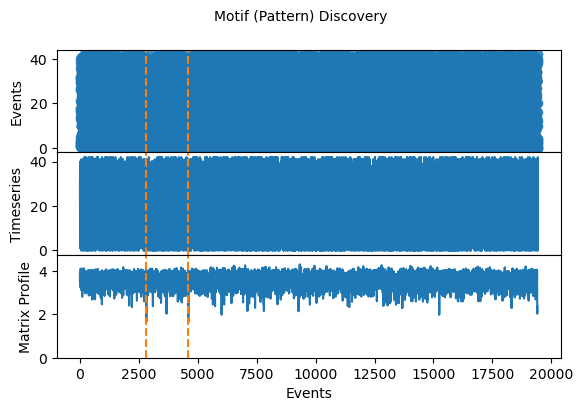

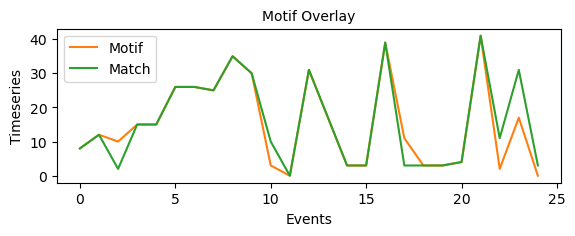

In [9]:
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0}, figsize=(6.5, 4))
plt.suptitle('Motif (Pattern) Discovery', fontsize='10')

#Plot Event data
axs[0].scatter(rows, ids, alpha=0.8)
axs[0].set_ylabel('Events', fontsize='10')
# Plot Timeseries data
axs[1].plot(event_series)
axs[1].set_ylabel('Timeseries', fontsize='10')
rect = Rectangle((motif_idx_tm, 0), window_size, event_series.max(), facecolor='lightgrey')
axs[1].add_patch(rect)
rect = Rectangle((nearest_neighbor_idx_tm, 0), window_size, event_series.max(), facecolor='lightgrey')
axs[1].add_patch(rect)
# Plot Matrix profiles
axs[2].set_xlabel('Events', fontsize ='10')
axs[2].set_ylabel('Matrix Profile', fontsize='10')
axs[2].set_ylim(top=tm_matrix[:, 0].max()*1.1) #displaying the max value with some uplift for space in Graph
axs[2].plot(tm_matrix[:, 0])
# Adding Dashed lines
axs[0].axvline(x=motif_idx_tm, linestyle="dashed", color='C1')
axs[0].axvline(x=nearest_neighbor_idx_tm, linestyle="dashed", color='C1')
axs[1].axvline(x=motif_idx_tm, linestyle="dashed", color='C1')
axs[1].axvline(x=nearest_neighbor_idx_tm, linestyle="dashed", color='C1')
axs[2].axvline(x=motif_idx_tm, linestyle="dashed", color='C1')
axs[2].axvline(x=nearest_neighbor_idx_tm, linestyle="dashed", color='C1')
plt.show()

# Display Pattern overlay
fig, ax = plt.subplots(figsize=(6.5, 2))
plt.title('Motif Overlay', fontsize='10')
ax.set_xlabel("Events", fontsize='10')
ax.set_ylabel("Timeseries", fontsize='10')
# Plot motif and nearest neighbor window
ax.plot(event_series[motif_idx_tm:motif_idx_tm+window_size], color='C1', label="Motif")
ax.plot(event_series[nearest_neighbor_idx_tm:nearest_neighbor_idx_tm+window_size], color='C2', label="Match")
plt.legend(loc="best",fontsize=10)
plt.show()

In [10]:
# Print the desired rows
display(df.iloc[motif_idx_tm:min(motif_idx_tm + window_size, len(df))])
display(df.iloc[nearest_neighbor_idx_tm:min(nearest_neighbor_idx_tm + window_size, len(df))])

,Unnamed: 0,case:concept:name,case:creator,lifecycle:transition,time:timestamp,org:resource,category,application,concept:name,event_src_path,...,tag_html,tag_href,tag_innerText,tag_option,tag_attributes,xpath,xpath_full,application:id,concept:name:id,category:id
4600,3600,712195850000000,SmartRPA by marco2012,complete,2020-07-12T19:59:32.000,shelbystark,Browser,Chrome,clickRadioButton,NaN,...,NaN,NaN,NaN,NaN,NaN,"id(""cultural"")","id(""cultural"")",1,20,1
4601,3601,712195850000000,SmartRPA by marco2012,complete,2020-07-12T20:00:17.000,shelbystark,Browser,Chrome,newTab,NaN,...,NaN,NaN,NaN,NaN,NaN,"id(""cultural"")","id(""cultural"")",1,25,1
4602,3611,712195850000000,SmartRPA by marco2012,complete,2020-07-12T20:07:16.000,shelbystark,Browser,Chrome,enableBrowserExtension,NaN,...,NaN,NaN,NaN,NaN,NaN,"id(""political/div[1]/url[0]"")","id(""political/div[1]/url[0]"")",1,34,1
4603,3603,712195850000000,SmartRPA by marco2012,complete,2020-07-12T20:01:40.000,shelbystark,Browser,Chrome,unpinnedTab,NaN,...,NaN,NaN,NaN,NaN,NaN,"id(""political/div[1]/url[0]"")","id(""political/div[1]/url[0]"")",1,22,1
4604,3604,712195850000000,SmartRPA by marco2012,complete,2020-07-12T20:02:32.000,shelbystark,Browser,Chrome,unpinnedTab,NaN,...,NaN,NaN,NaN,NaN,NaN,"id(""political/div[1]/url[0]"")","id(""political/div[1]/url[0]"")",1,22,1
4605,3605,712195850000000,SmartRPA by marco2012,complete,2020-07-12T20:02:59.000,shelbystark,MicrosoftOffice,Microsoft Excel,sheetCalculate,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,6,2
4606,3606,712195850000000,SmartRPA by marco2012,complete,2020-07-12T20:03:30.000,shelbystark,MicrosoftOffice,Microsoft Excel,sheetCalculate,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,6,2
4607,3607,712195850000000,SmartRPA by marco2012,complete,2020-07-12T20:04:22.000,shelbystark,MicrosoftOffice,Microsoft Excel,selectWorksheet,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,14,2
4608,3609,712195850000000,SmartRPA by marco2012,complete,2020-07-12T20:05:54.000,shelbystark,MicrosoftOffice,Microsoft PowerPoint,openPresentation,/family/ok.doc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,2
4609,3610,712195850000000,SmartRPA by marco2012,complete,2020-07-12T20:06:49.000,shelbystark,OperatingSystem,Clipboard,paste,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,32,0


,Unnamed: 0,case:concept:name,case:creator,lifecycle:transition,time:timestamp,org:resource,category,application,concept:name,event_src_path,...,tag_html,tag_href,tag_innerText,tag_option,tag_attributes,xpath,xpath_full,application:id,concept:name:id,category:id
2819,3600,712195850000000,SmartRPA by marco2012,complete,2020-07-12T19:59:32.000,shelbystark,Browser,Chrome,clickRadioButton,NaN,...,NaN,NaN,NaN,NaN,NaN,"id(""cultural"")","id(""cultural"")",1,20,1
2820,3601,712195850000000,SmartRPA by marco2012,complete,2020-07-12T20:00:17.000,shelbystark,Browser,Chrome,newTab,NaN,...,NaN,NaN,NaN,NaN,NaN,"id(""cultural"")","id(""cultural"")",1,25,1
2821,3624,712195850000000,SmartRPA by marco2012,complete,2020-07-12T20:13:49.000,shelbystark,OperatingSystem,Explorer,openFolder,/forward/year.mov,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,39,0
2822,3603,712195850000000,SmartRPA by marco2012,complete,2020-07-12T20:01:40.000,shelbystark,Browser,Chrome,unpinnedTab,NaN,...,NaN,NaN,NaN,NaN,NaN,"id(""political/div[1]/url[0]"")","id(""political/div[1]/url[0]"")",1,22,1
2823,3604,712195850000000,SmartRPA by marco2012,complete,2020-07-12T20:02:32.000,shelbystark,Browser,Chrome,unpinnedTab,NaN,...,NaN,NaN,NaN,NaN,NaN,"id(""political/div[1]/url[0]"")","id(""political/div[1]/url[0]"")",1,22,1
2824,3605,712195850000000,SmartRPA by marco2012,complete,2020-07-12T20:02:59.000,shelbystark,MicrosoftOffice,Microsoft Excel,sheetCalculate,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,6,2
2825,3606,712195850000000,SmartRPA by marco2012,complete,2020-07-12T20:03:30.000,shelbystark,MicrosoftOffice,Microsoft Excel,sheetCalculate,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,6,2
2826,3607,712195850000000,SmartRPA by marco2012,complete,2020-07-12T20:04:22.000,shelbystark,MicrosoftOffice,Microsoft Excel,selectWorksheet,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,14,2
2827,3609,712195850000000,SmartRPA by marco2012,complete,2020-07-12T20:05:54.000,shelbystark,MicrosoftOffice,Microsoft PowerPoint,openPresentation,/family/ok.doc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,2
2828,3610,712195850000000,SmartRPA by marco2012,complete,2020-07-12T20:06:49.000,shelbystark,OperatingSystem,Clipboard,paste,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,32,0


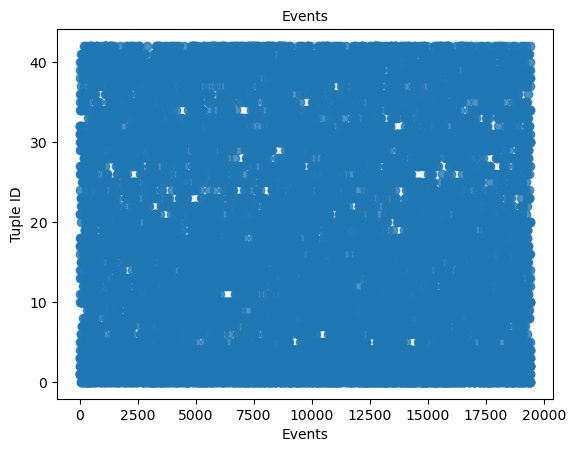

In [11]:
# Events only plot
fig, ax = plt.subplots()
plt.title('Events', fontsize='10')
ax.set_xlabel("Events", fontsize='10')
ax.set_ylabel("Tuple ID", fontsize='10')
ax.scatter(rows, ids, alpha=0.8)
plt.show()

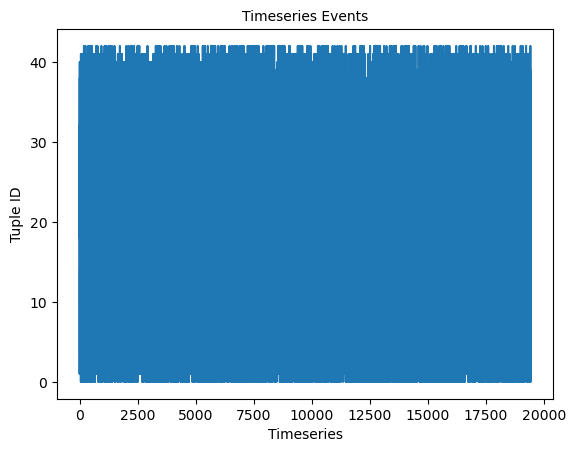

In [12]:
# Matrix Profil only
fig, ax = plt.subplots()
plt.title('Timeseries Events', fontsize='10')
ax.set_xlabel("Timeseries", fontsize='10')
ax.set_ylabel("Tuple ID", fontsize='10')
ax.plot(event_series)
# Plot motif and nearest neighbor window
plt.show()

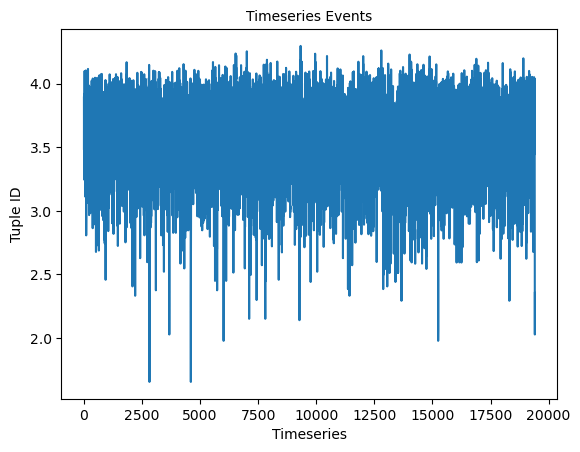

In [13]:
#Timeseries plot only
fig, ax = plt.subplots()
plt.title('Timeseries Events', fontsize='10')
ax.set_xlabel("Timeseries", fontsize='10')
ax.set_ylabel("Tuple ID", fontsize='10')
ax.plot(tm_matrix[:, 0])
plt.show()

## Find Top-K Motifs

From https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html#Find-Top-K-Motifs

Now that you’ve computed the matrix profile, mp, for your time series and identified the best global motif, you may be interested in discovering other motifs within your data. However, you’ll immediately learn that doing something like top_10_motifs_idx = np.argsort(mp[:, 0])[10] doesn’t actually get you what you want and that’s because this only returns the index locations that are likely going to be close to the global motif! Instead, after identifying the best motif (i.e., the matrix profile location with the smallest value), you first need to exclude the local area (i.e., an exclusion zone) surrounding the motif pair by setting their matrix profile values to np.inf before searching for the next motif. Then, you’ll need to repeat the “exclude-and-search” process for each subsequent motif. Luckily, STUMPY offers two additional functions, namely, stumpy.motifs and stumpy.match, that help simplify this process. While it is beyond the scope of this basic tutorial, we encourage you to check them out!



In [14]:
# ToDo: When a motif is discovered: Find all equal motifs in the data and extract (CTRL+X) them from the frame into a new frame
#    this new frame contains all variants of a motif and could be input to smartRPAs routine variant discovery
# Repeat until no motifs are found anymore

# min_neighbours: With min_neighbours one can select how often a process motif has to appear at least to be relevant => map this to number of executions
# max_matches
top_motifs = stumpy.motifs(T=event_series, P=tm_matrix[:,0], min_neighbors=1, max_matches=10)
top_motifs

(array([[3.16101364e-07, 1.65292130e+00, 2.13883949e+00, 2.94750944e+00,
         3.35473187e+00, 3.51065143e+00, 3.71898917e+00, 3.72162904e+00,
         3.94860990e+00, 3.96236549e+00]]),
 array([[ 2819,  4600,  9274,  7434, 11268, 18667, 15524, 18499,  3736,
          5055]], dtype=int64))

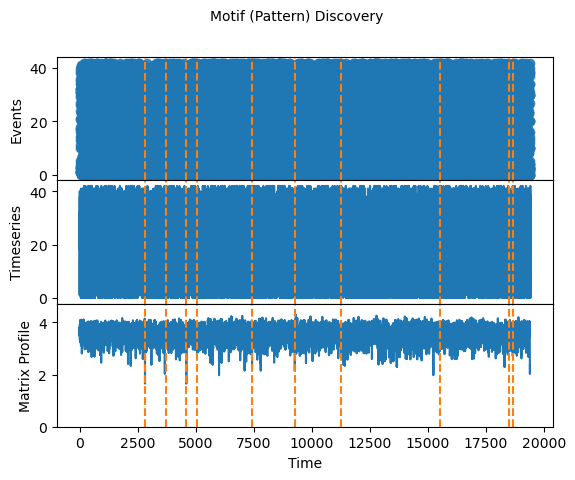

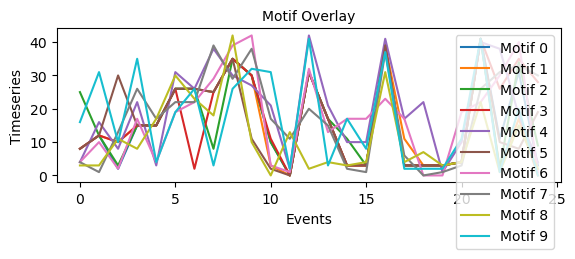

In [15]:
#Plot Event data
fig2, axs2 = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='10')

axs2[0].scatter(rows, ids, alpha=0.8)
axs2[0].set_ylabel('Events', fontsize='10')
# Plot Timeseries data
axs2[1].plot(event_series)
axs2[1].set_ylabel('Timeseries', fontsize='10')
rect = Rectangle((motif_idx_tm, 0), window_size, event_series.max(), facecolor='lightgrey')
# axs2[1].add_patch(rect)
rect = Rectangle((nearest_neighbor_idx_tm, 0), window_size, event_series.max(), facecolor='lightgrey')
# axs2[1].add_patch(rect)
# Plot Matrix profiles
axs2[2].set_xlabel('Time', fontsize ='10')
axs2[2].set_ylabel('Matrix Profile', fontsize='10')
axs2[2].set_ylim(top=tm_matrix[:, 0].max()*1.1) #displaying the max value with some uplift for space in Graph
axs2[2].plot(tm_matrix[:, 0])
# Adding Dashed lines
for discovered in top_motifs[1][0]:
    axs2[0].axvline(x=discovered, linestyle="dashed",color='C1')
    axs2[1].axvline(x=discovered, linestyle="dashed",color='C1')
    axs2[2].axvline(x=discovered, linestyle="dashed",color='C1')

# Display Pattern overlay
fig, ax = plt.subplots(figsize=(6.5, 2))
plt.title('Motif Overlay', fontsize='10')
ax.set_xlabel("Events", fontsize='10')
ax.set_ylabel("Timeseries", fontsize='10')
# Plot motif and nearest neighbor window
for i, val in enumerate(top_motifs[1][0]):
    colorPlot = 'C' + str(i)
    ax.plot(event_series[val:val+window_size], color=colorPlot, label=f"Motif {i}")
    
plt.legend(loc="best",fontsize=10)
plt.show()

plt.show()